## **Setup + Introduction**

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as lyrs, optimizers as opts, activations as acts, losses as ls

import matplotlib.pyplot as plt


## **Training, evaluation, and inference**

>> **The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build `graphs of layers`.**

In [2]:
'''
    Creating a Linear totplogy using functional layer!!
    Topology:
        Inputs([784]) => Dense(units= 64, 'relu') => Dense(units= 32, 'relu') => Dense(units= 10, 'softmax')
'''

inp = tfk.Input(shape=[784], name='Input_Layer')
d1 = lyrs.Dense(128, 'relu', name= 'Dense_1')(inp)
d2 = lyrs.Dense(64, 'relu', name= 'Dense_2')(d1)
out = lyrs.Dense(10, 'softmax', name= 'OutputLayer')(d2)


model = tfk.Model(inputs= inp, outputs= out, name='Classification_Model')
model.summary()


Model: "Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               100480    
                                                                 
 Dense_2 (Dense)             (None, 64)                8256      
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


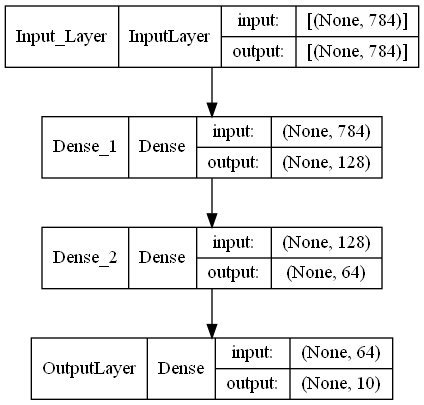

In [5]:
tfk.utils.plot_model(model, to_file='model.png', show_shapes= True)

In [6]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

'''
    1. Preparing data
    2. Building the Model
    3. Train and evaluate 
'''

dataset = tfk.datasets.mnist
(tr_data, tr_lbls), (ts_data, ts_lbls) = dataset.load_data()

# We Flatten the incoming tensor, to convert its dimensions from [28, 28] to (28 x 28)
# We use astype to change type of data

print(tr_data.shape)
print(tr_data.dtype)

tr_data = lyrs.Flatten()(tr_data).astype('float32') / 255.0
ts_data = ts_data.reshape(-1,784).astype('float32') / 255.0

print(ts_data.shape)
print(tr_data.dtype)


(60000, 28, 28)
uint8
(10000, 784)
<dtype: 'float32'>


In [3]:
model.compile(
    optimizer= opts.Adam(learning_rate= 0.005),
    loss= ls.SparseCategoricalCrossentropy(),
    metrics= ['accuracy']
)

his = model.fit(
    tr_data,
    tr_lbls,
    validation_split=0.25,
    batch_size=64,
    epochs=20,
    verbose=1
)

NameError: name 'tr_data' is not defined

In [51]:


def plot_history(history, metric):
    r = len(history[metric])
    plt.plot(history[metric], label='Training')
    plt.plot(history['val_'+ metric], label='Validation')
    plt.title(metric)
    
    if metric == 'loss':
        plt.ylim([0, 1])
    else:
        plt.ylim([0.9, 1.0])
    plt.legend()
        

history = his.history
print(history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


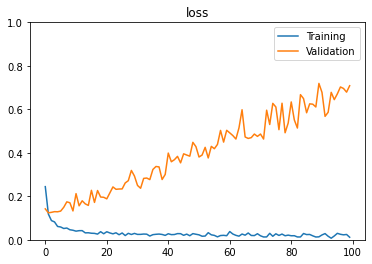

In [52]:

plot_history(history, 'loss')


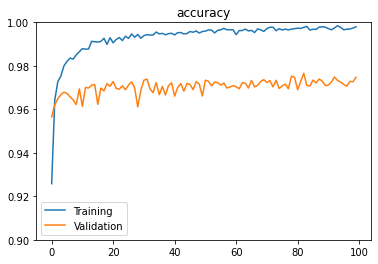

In [53]:

plot_history(history, 'accuracy')


## **Save and serialize**
**The standard way to save a functional model is to call model.save() to save the entire model as a single file. You can later recreate the same model from this file, even if the code that built the model is no longer available.**

> **`The Saved Model includes:`**
1. **Model Architecture**
2. **Model Weights**
3. **Model training config**
4. **Optimizer and its state**

In [72]:
# # save Model
# model.save('SavedModel')

# # delete existing model
# del model

# Reloading Model
model_loaded = tfk.models.load_model('SavedModel')
pred = model_loaded(ts_data[:10])


tf.nn.softmax(pred)
for i in pred:
    print(np.argmax(i))
    

7
2
1
0
4
1
4
9
6
9


## **Reusing graph of layers to define multiple**

In [98]:
# First we will create an Encoder by stacking layers.
# Then, we will reuse the existing layers graph to instantiate new model that decodes the encoder-output.

encoder_inp = lyrs.Input((28, 28, 1), name='InputLayer')
x = lyrs.Conv2D(128, 3, activation='relu')(encoder_inp)
x = lyrs.Conv2D(64, 3, activation='relu')(x)
x = lyrs.MaxPooling2D(3)(x)
x = lyrs.Conv2D(32, 3, activation='relu')(x)
x = lyrs.Conv2D(16, 3, activation='relu')(x)
encoder_out = lyrs.GlobalMaxPooling2D()(x)

model_encoder = tfk.Model(encoder_inp, encoder_out, name='Encoder')
model_encoder.summary()


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 6, 6, 32)          18464     
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

In [99]:
# Now creating the decoder!!
autoencoder_inp = lyrs.Reshape((4, 4, 1))(encoder_out)
x = lyrs.Conv2DTranspose(128, 3, activation='relu')(autoencoder_inp)
x = lyrs.Conv2DTranspose(64, 3, activation='relu')(x)
x = lyrs.UpSampling2D(3)(x)
x = lyrs.Conv2DTranspose(32, 3, activation='relu')(x)
autoencoder_out = lyrs.Conv2DTranspose(1, 3, activation='relu')(x)

model_autoencoder = tfk.Model(encoder_inp, autoencoder_out, name='autoencoder')
model_autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 6, 6, 32)          18464     
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 16)          4624      
                                                       

## **Callable Models, just like layers**

> **Treating `NeuralNet-Models` like `KerasLayers` allows us to design modular-Models, which can take in any specific input and produce an output. Models can also be combined||stacked like layers to form pipelines(Model architecture)**

In [ ]:
"""
    In this part, we are going to form a autoencoder by 
    first creating seperate encoders and decoders, then chaining them together 
    to form autoencoder architecture
"""

Encoder_Inp = tfk.Input(shape=(150, 150, 1), name='Encoded_Image')
lyr = lyrs.Conv2D(256, 3, activation='relu')(Encoder_Inp)
lyr = lyrs.Conv2D(256, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(256, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(3)(lyr)

lyr = lyrs.Conv2D(128, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(128, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(2)(lyr)

lyr = lyrs.Conv2D(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(16, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(3)(lyr)
Encoder_Out = lyrs.GlobalMaxPooling2D()(lyr)

ModelEncoder = tfk.Model(Encoder_Inp, Encoder_Out, name='Encoder')
ModelEncoder.summary()


Decoder_Inp = tfk.Input(shape=(25, ), name='Encoded_Image')
lyr = lyrs.Reshape((5, 5, 1))(Decoder_Inp)
lyr = lyrs.UpSampling2D(3)(lyr)

lyr = lyrs.Conv2DTranspose(16, 2, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.UpSampling2D(2)(lyr)

lyr = lyrs.Conv2DTranspose(128, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(128, 3, activation='relu')(lyr)
lyr = lyrs.UpSampling2D(3)(lyr)

lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
output = lyrs.Conv2DTranspose(1, 3, activation='relu')(lyr)

ModelDecoder = tfk.Model(Decoder_Inp, output, name='Decoder')
ModelDecoder.summary()

autoenc_inp = tfk.Input((150, 150, 1), name='AutoEncoder_Input')

encoded_image = ModelEncoder(autoencoder_inp)
decoded_image = ModelDecoder(encoded_image)

autoencoder = tfk.Model(autoenc_inp, decoded_image, name='AutoEncoder')
autoencoder.summary()

In [133]:
encoder_input = tfk.Input(shape=(28, 28, 1), name="original_img")
x = lyrs.Conv2D(16, 3, activation="relu")(encoder_input)
x = lyrs.Conv2D(32, 3, activation="relu")(x)
x = lyrs.MaxPooling2D(3)(x)
x = lyrs.Conv2D(32, 3, activation="relu")(x)
x = lyrs.Conv2D(16, 3, activation="relu")(x)
encoder_output = lyrs.GlobalMaxPooling2D()(x)

encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = tfk.Input(shape=(16,), name="encoded_img")
x = lyrs.Reshape((4, 4, 1))(decoder_input)
x = lyrs.Conv2DTranspose(16, 3, activation="relu")(x)
x = lyrs.Conv2DTranspose(32, 3, activation="relu")(x)
x = lyrs.UpSampling2D(3)(x)
x = lyrs.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = lyrs.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = tfk.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = tfk.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = tfk.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_228 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 conv2d_229 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_230 (Conv2D)         (None, 6, 6, 32)          9248      
                                                                 
 conv2d_231 (Conv2D)         (None, 4, 4, 16)          4624      
                                                           

In [ ]:
def get_Model():
    pass

## **Manipulate complex graph topologies**

> #### **Multi Input||Outputs**

**Printing Movie Tickets for customers**

**`Inputs:`**
1. The Title of the ticket
2. The text body of the ticket(categorical input)
3. Tags added by the user

**`Outputs:`**
1. Priority between 0-1
2. The department that should handle the ticket(softmax over the set of departments)


In [4]:
num_tags = 12 # Number of unique issue-tags.
num_words = 10000 # Size of vocabulary when preprocessing the text.
num_depts = 4 # Number of departments for predictions.

In [19]:
# Defining Inputs for a ticket

title_input = tfk.Input(
    shape= (None, ), name='titles'
) # Variable-length sequence of ints.

body_input = tfk.Input(
    shape=(None, ), name='text'
) # Variable-length sequence of ints.

tags_input = tfk.Input(
    shape=(num_tags, ), name='tags'
) # Binary-vectors of size 'num_tags'


Im here


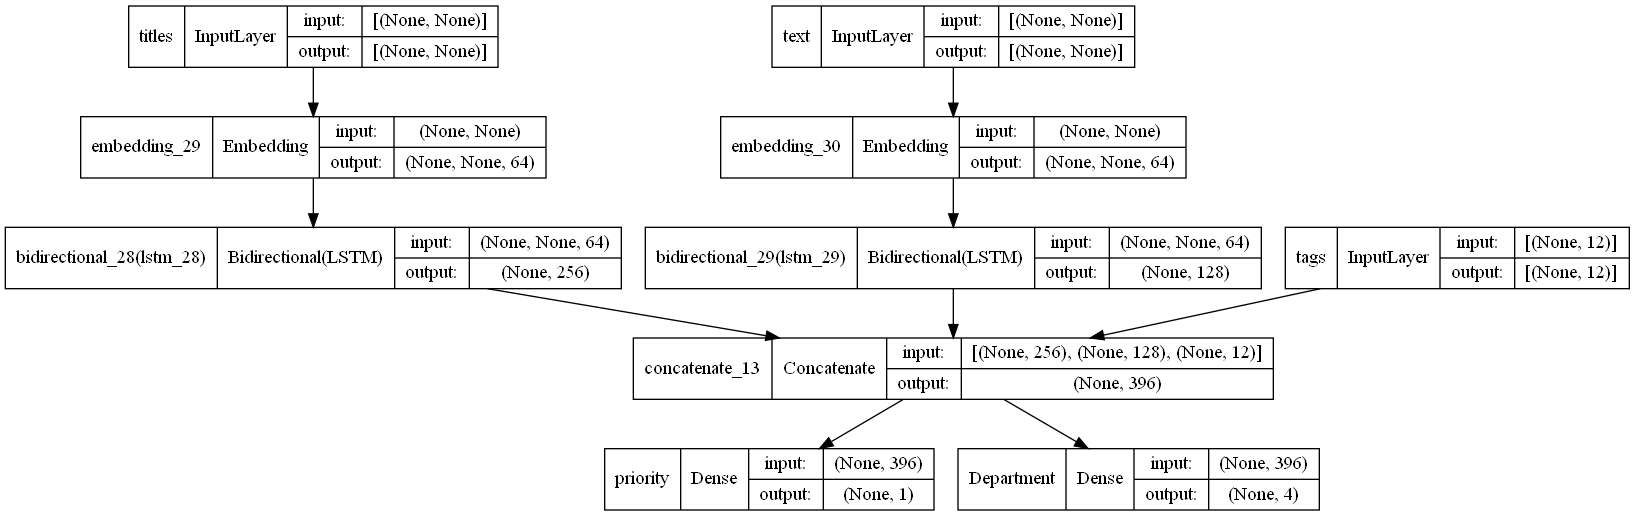

In [31]:
"""
    First create 64-dimensional embeddings for each title word and each text words
    Reduce sequence of words into a single (n) dimensional vector
"""

# Embed each title-word, text-words into a 64 dimensional vector.
title_features = lyrs.Embedding(num_words, 64)(title_input)
text_features  = lyrs.Embedding(num_words, 64)(body_input)

# Reduce sequences to a single vector using LSTM layers
title_features = lyrs.Bidirectional(
    lyrs.LSTM(128, activation='tanh')
)(title_features) # Vector with (128*2, ) dimension

text_features = lyrs.Bidirectional(
    lyrs.LSTM(64, activation='tanh')
)(text_features)  # Vector with (48*2, ) dimension

# Merge all layers into one layer
x = lyrs.concatenate([title_features, text_features, tags_input])
# Stick a logistic regression chapee on top of the combined Inputs to get priority for a ticekt..
# Priority [0.0-1.0].

priority_perdiction = lyrs.Dense(1, name='priority')(x)
# Create another layer for predicting department.
dept_pridiction = lyrs.Dense(4, name='Department')(x)

print("Im here")


inputs = [title_input, body_input, tags_input]
outputs = [priority_perdiction, dept_pridiction]

model = tfk.Model(
    inputs, outputs, name='Ticket_prediction_Model'
)

tfk.utils.plot_model(model, 'Ticket_classifier.png', show_shapes= True)

In [32]:
# Compiling the Model and assigning weights
# We can assign seperate (perhaps optimizers) losses to each of the ouptuts in the Model

model.compile(
    optimizer= [
        opts.Adam(),
        opts.Adadelta(),
    ],
    
    loss= [
        ls.BinaryCrossentropy(from_logits= True),
        ls.SparseCategoricalCrossentropy(from_logits= True)
    ],
    
    # loss_weights=[1.0, 2.0],
    # loss_weights={"priority": 1.0, "department": 0.2} :: Specifying layers to add specific weights
    # metrics=['accuracy']
)

In [29]:
# Training the Model with dumy data to see the results.

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_depts))

model.fit(
    {"titles": title_data, "text": body_data, "tags": tags_data},
    {"priority": priority_targets, "Department": dept_targets},
    epochs=2,
    batch_size=32,
)


Epoch 1/2


ValueError: in user code:

    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "C:\Users\ahsan\anaconda3\envs\Graphs_IDS\lib\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(128,) and logits.shape=(32, 4)


> #### **Mini Resnet**

## **Shared Layers**

## **Extract and reuse Nodes in graph of layers**

## **Extend the Func-API using custom-layers**

## **Practical Use**

> #### **Strengths**

> #### **Weaknesses**

## **Mix n Match API styles**